# Introduction

The [Zillow Prize Competition](https://www.kaggle.com/c/zillow-prize-1/overview) is asking us to predict the `log-error` between their `Zestimate` and the `actual sale price`, given all the features of a home.
The log error is defined as `logerror = log(Zestimate) - log(SalePrice)`

The goal of this notebook is to explore and elaborate the datasets provided by the competition.

# Setup
Let us import the required modules.

In [3]:
import numpy as np # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import seaborn as sns # might not be needed
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

color = sns.color_palette()
pd.set_option("display.max_columns", 100) #Display up to 100 columns
%matplotlib inline

import sys
import os
sys.path.insert(0, os.path.abspath("../../"))

from sklearn.ensemble import RandomForestRegressor

# sostituire se ho i file, sono solo per importare script python scritti da me
import project.src.feat_eng as fe
# import project.src.training as tr
import project.src.visualization as viz
# import project.src.utils as utils
# import project.src.dataset_manager as dm

# RND_SEED = utils.RND_SEED #non so a cosa serva sinceramente
np.random.seed(1)

# Load Data

We are going to use 2017 data since it's newer, and it does not differ much from the 2016.
The data we are using are the following:
- `properties_2017.csv` - all the properties with their home features for 2017
- `train_2017.csv` - the training set with transactions from 01/01/2017 to 15/09/2017

In [4]:
properties_2017 = pd.read_csv('../data/zillow-prize-1/properties_2017.csv')
train_2017 = pd.read_csv('../data/zillow-prize-1/train_2017.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Property data

In [5]:
print('Shape: ', properties_2017.shape)

Shape:  (2985217, 58)


In [6]:
print('Info: ')
properties_2017.info(verbose=True)

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   parcelid                      int64  
 1   airconditioningtypeid         float64
 2   architecturalstyletypeid      float64
 3   basementsqft                  float64
 4   bathroomcnt                   float64
 5   bedroomcnt                    float64
 6   buildingclasstypeid           float64
 7   buildingqualitytypeid         float64
 8   calculatedbathnbr             float64
 9   decktypeid                    float64
 10  finishedfloor1squarefeet      float64
 11  calculatedfinishedsquarefeet  float64
 12  finishedsquarefeet12          float64
 13  finishedsquarefeet13          float64
 14  finishedsquarefeet15          float64
 15  finishedsquarefeet50          float64
 16  finishedsquarefeet6           float64
 17  fips                          float64
 18  fireplacecnt   

In [7]:
print('Description: ')
properties_2017.describe().T

Description: 


,count,mean,std,min,25%,50%,75%,max
parcelid,2985217.0,1.332586e+07,7.909966e+06,1.071172e+07,1.164371e+07,1.254509e+07,1.409712e+07,1.696019e+08
airconditioningtypeid,815362.0,1.945723e+00,3.160507e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,6061.0,7.202607e+00,2.436290e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.700000e+01
basementsqft,1627.0,6.472207e+02,5.387871e+02,2.000000e+01,2.720000e+02,5.350000e+02,8.475000e+02,8.516000e+03
bathroomcnt,2982260.0,2.216196e+00,1.078250e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.200000e+01
bedroomcnt,2982272.0,3.093362e+00,1.271569e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,2.500000e+01
buildingclasstypeid,12731.0,3.734742e+00,5.003709e-01,1.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00
buildingqualitytypeid,1941395.0,6.280822e+00,1.729923e+00,1.000000e+00,5.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,2868061.0,2.303826e+00,1.003243e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.200000e+01
decktypeid,17379.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


In [8]:
properties_2017.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,1959.0,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


# Target Variable
The target variable we need to predict is `logerror`.
Let's do some analysis on this variable.

In [9]:
print('Shape: ', train_2017.shape)

Shape:  (77613, 3)


In [10]:
print('Info: ')
train_2017.info(verbose=True)

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcelid         77613 non-null  int64  
 1   logerror         77613 non-null  float64
 2   transactiondate  77613 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.8+ MB


In [11]:
print('Description: ')
train_2017.logerror.describe().T

Description: 


count    77613.000000
mean         0.016755
std          0.170887
min         -4.655420
25%         -0.024325
50%          0.006670
75%          0.039295
max          5.262999
Name: logerror, dtype: float64

In [12]:
train_2017.head()

,parcelid,logerror,transactiondate
0,14297519,0.025595,2017-01-01
1,17052889,0.055619,2017-01-01
2,14186244,0.005383,2017-01-01
3,12177905,-0.103410,2017-01-01
4,10887214,0.006940,2017-01-01


# Merging Train and Properties datasets

We can see that `Train data` misses a lot of properties compared to `Properties data`, so we merge them and ignore those for which we do not have `log-error`.

Since `parcelid` is the unique identifier for the 2 tables, we will merge based on that to form our complete dataset.

In [13]:
merged_df = properties_2017.merge(train_2017,on = 'parcelid',how = 'inner')
merged_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,17054981,NaN,NaN,NaN,5.0,4.0,NaN,NaN,5.0,NaN,1968.0,3760.0,3760.0,NaN,NaN,1968.0,NaN,6111.0,4.0,5.0,3.0,784.0,NaN,NaN,34449407.0,-119254052.0,42688.0,1.0,735.0,NaN,NaN,1.0,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,1982.0,2.0,NaN,501928.0,872850.0,2016.0,370922.0,9673.46,NaN,NaN,6.111001e+13,-0.013099,2017-06-15
1,17055743,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,66.0,1444.0,1444.0,1444.0,NaN,NaN,1444.0,NaN,6111.0,NaN,2.0,1.0,0.0,NaN,NaN,34454169.0,-119237898.0,7108.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1951.0,1.0,NaN,130845.0,436157.0,2016.0,305312.0,5538.80,NaN,NaN,6.111001e+13,0.073985,2017-07-26
2,17068109,NaN,NaN,NaN,1.5,3.0,NaN,NaN,1.5,66.0,1698.0,1698.0,1698.0,NaN,NaN,1698.0,NaN,6111.0,1.0,1.0,0.0,0.0,NaN,NaN,34365693.0,-119448392.0,2588.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,34543.0,2061.0,NaN,97081.0,6.0,NaN,1.0,NaN,NaN,NaN,NaN,1979.0,1.0,NaN,193413.0,286606.0,2016.0,93193.0,2987.36,NaN,NaN,6.111001e+13,0.071886,2017-07-28
3,17073952,NaN,NaN,NaN,2.0,2.0,NaN,NaN,2.0,NaN,986.0,986.0,986.0,NaN,NaN,986.0,NaN,6111.0,1.0,2.0,1.0,0.0,NaN,NaN,34305600.0,-119284000.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,266.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97081.0,4.0,NaN,NaN,NaN,NaN,55.0,NaN,1989.0,1.0,NaN,90357.0,258888.0,2016.0,168531.0,2706.24,NaN,NaN,6.111002e+13,0.305680,2017-06-02
4,17078502,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1170.0,1170.0,1170.0,NaN,NaN,1170.0,NaN,6111.0,1.0,1.0,2.0,621.0,NaN,NaN,34278012.0,-119257047.0,5643.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97083.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,148752.0,592930.0,2016.0,444178.0,6220.70,NaN,NaN,6.111002e+13,-0.073787,2017-07-07


In [14]:
print('Shape: ', merged_df.shape)

Shape:  (77613, 60)


### Saving the merged dataset

In [15]:
merged_df.to_csv('../data/merged_dataset_2017.csv', index=False)

### Saving actual properties dataset
Saving actual properties data might come in handy later

In [16]:
actual_data = merged_df.drop(columns=["logerror", "transactiondate"])
actual_data.to_csv('../data/actual_properties_2017.csv', index=False)

# Exploratory Data Analysis
The merged dataset `merged_df` contains 77613 rows and 60 columns, but we don't need `parcelid`, `logerror` and `transactiondate` for prediction.

Let's analyse the dataset to identify the following:
- Missing values
- Unique values
- Numerical variables
- Categorical variables
- Distribution of all features
- Correlation

## Dataset Information:

In [17]:
# drop label useless for prediction
actual_data = actual_data.drop(columns=["parcelid"])
print('Shape: ', actual_data.shape)

Shape:  (77613, 57)


In [18]:
actual_data.columns

Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'y

In [19]:
print('Info: ')
actual_data.info(verbose=True)

Info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         25007 non-null  float64
 1   architecturalstyletypeid      207 non-null    float64
 2   basementsqft                  50 non-null     float64
 3   bathroomcnt                   77579 non-null  float64
 4   bedroomcnt                    77579 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   buildingqualitytypeid         49809 non-null  float64
 7   calculatedbathnbr             76963 non-null  float64
 8   decktypeid                    614 non-null    float64
 9   finishedfloor1squarefeet      6037 non-null   float64
 10  calculatedfinishedsquarefeet  77378 non-null  float64
 11  finishedsquarefeet12          73923 non-null  float64
 12  finishedsquarefeet13          42 non-null     float64

In [20]:
print('Description: ')
actual_data.describe().T

Description: 


,count,mean,std,min,25%,50%,75%,max
airconditioningtypeid,25007.0,1.812013e+00,2.965768e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,207.0,7.386473e+00,2.728030e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77579.0,2.298496e+00,9.967317e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77579.0,3.053223e+00,1.140480e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49809.0,6.533779e+00,1.722062e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76963.0,2.316392e+00,9.796893e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
decktypeid,614.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01
finishedfloor1squarefeet,6037.0,1.366165e+03,6.707013e+02,4.400000e+01,9.550000e+02,1.257000e+03,1.615000e+03,6.912000e+03


**Observations**
- The total number of properties is 2985217, but we will be only using 77613
- Lots of variables contain missing data.

## Missing values
Checking for Missing values

In [21]:
miss_val = [var for var in actual_data.columns if actual_data[var].isnull().sum()>0]
all_data_pct = ((actual_data.isnull().sum() / len(actual_data)) * 100).sort_values(ascending=False)
all_data_count = actual_data[miss_val].isnull().sum().sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing pct' :all_data_pct, 'Missing count' :all_data_count})
missing_data

,Missing pct,Missing count
buildingclasstypeid,99.980673,77598
finishedsquarefeet13,99.945885,77571
basementsqft,99.935578,77563
storytypeid,99.935578,77563
yardbuildingsqft26,99.909809,77543
fireplaceflag,99.778388,77441
architecturalstyletypeid,99.733292,77406
typeconstructiontypeid,99.712677,77390
finishedsquarefeet6,99.502661,77227
pooltypeid10,99.400874,77148


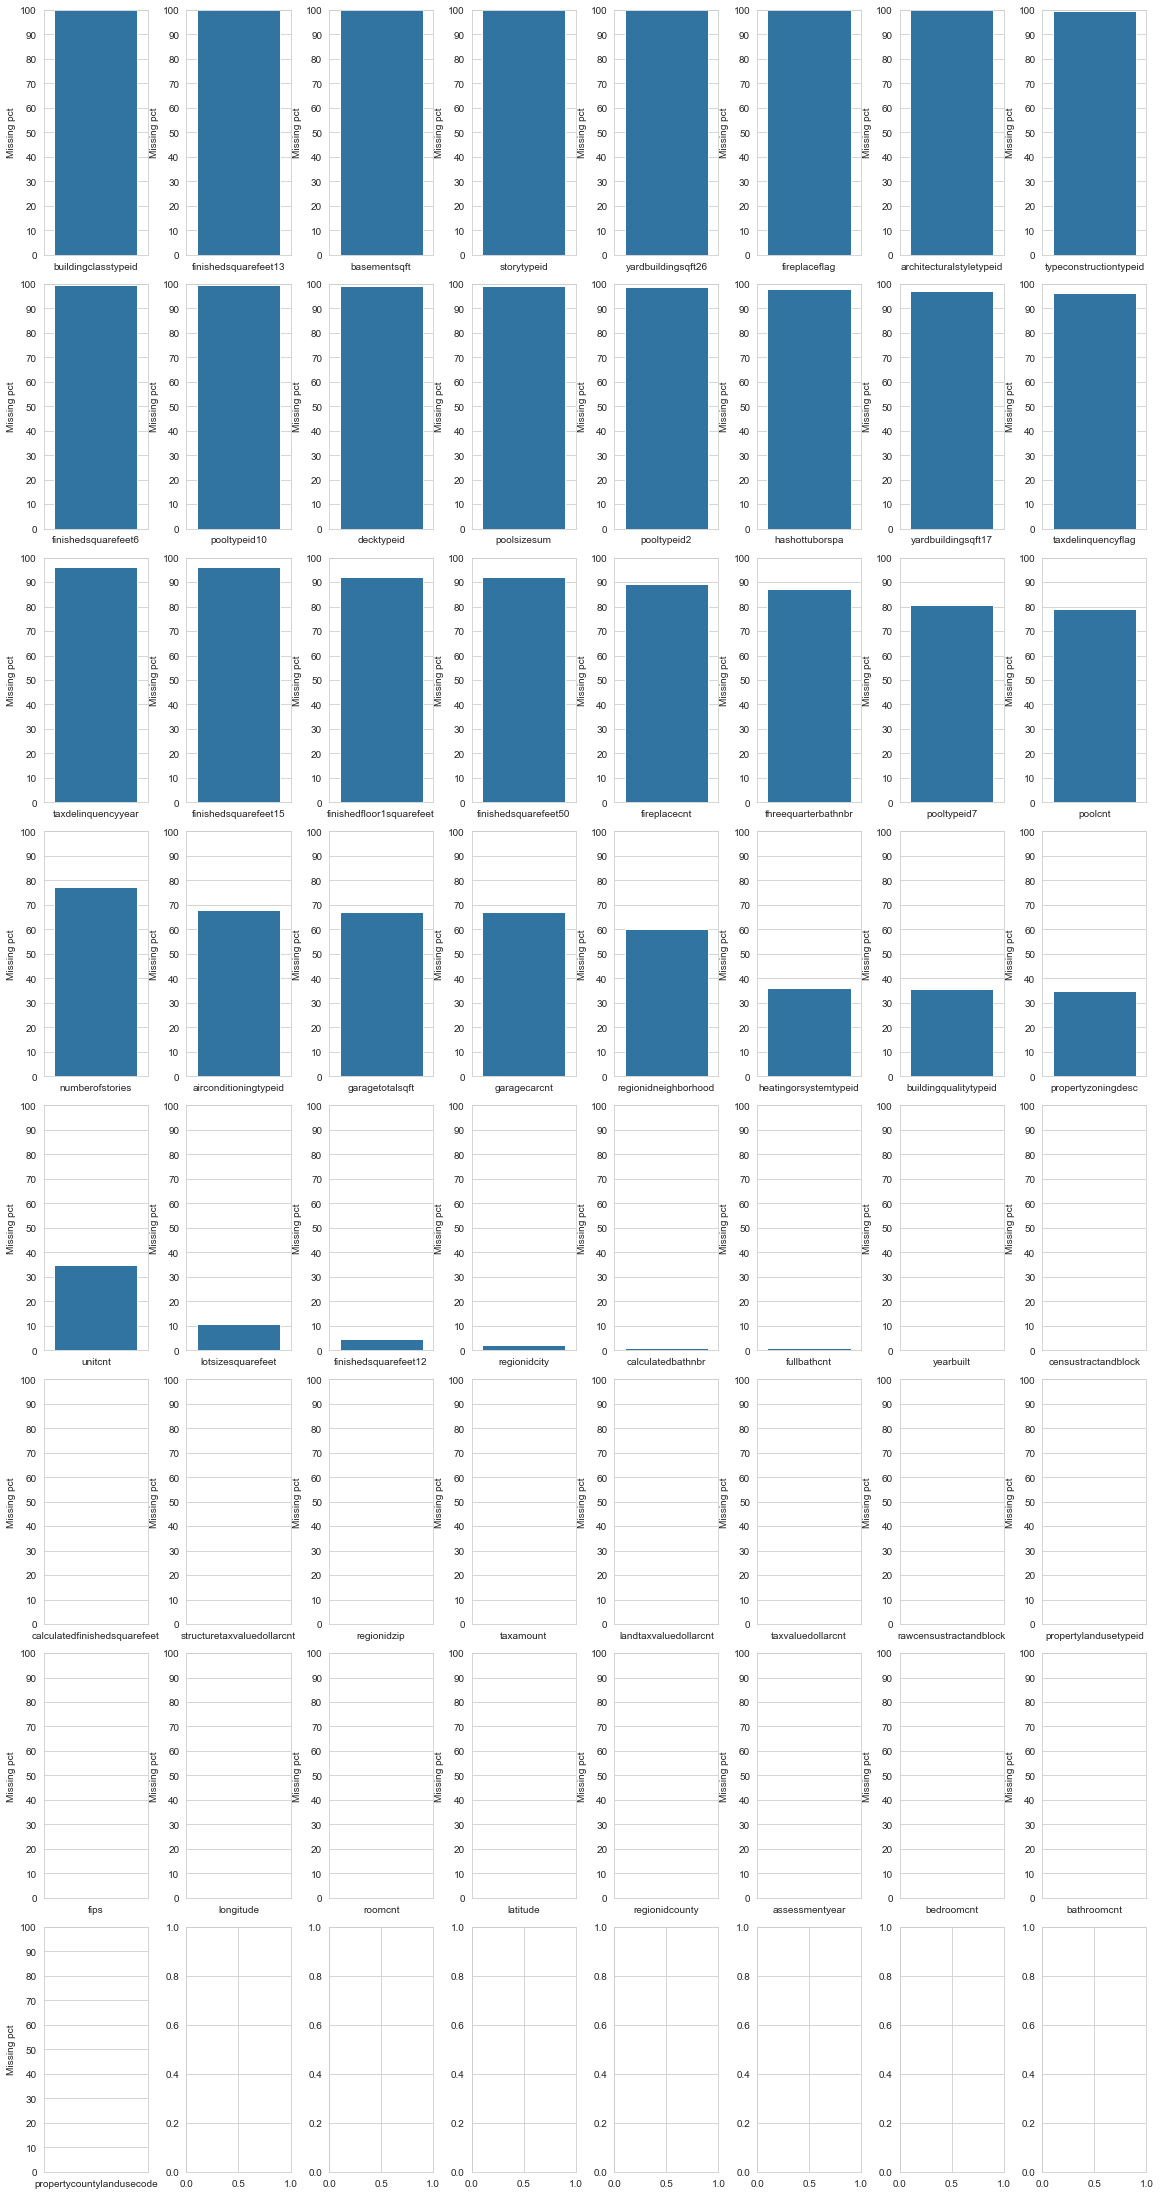

In [28]:
viz.missing_values_plot(data=missing_data, subplot_size=(2, 4), width=8)

## Unique values

In [29]:
# Check unique values of all feature
num_features = actual_data.shape[1]

for f in range(num_features):
    print (f, actual_data.iloc[:,f].unique())

0 [nan  1. 13.  5. 11.  9.]
1 [nan  7. 21.  8.  2.  3.]
2 [  nan  394.  314.  168. 1252.  396.  674.  819.  912.  204.  800. 1416.
  384.   90.  640.  380.  254.  600. 1809.  645.  786.  100.  669.  512.
  273.  300.  900.  200.  224.  515. 1969.  700.   38.  604.  405.  112.
 3112.  352. 1218.  588.  280.  252. 3560.  126.]
3 [ 5.   2.   1.5  1.   0.   2.5  3.   4.5  4.   6.   3.5  5.5  7.5  7.
 10.   8.   6.5  9.  11.   8.5 18.  13.   nan]
4 [ 4.  3.  2.  0.  5.  1.  6.  8. 11.  7.  9. 10. 12. 13. 16. 14. nan]
5 [nan  4.  3.]
6 [nan  6.  8.  7. 11.  9.  4.  3.  5. 10. 12.  1.  2.]
7 [ 5.   2.   1.5  1.   nan  2.5  3.   4.5  4.   6.   3.5  5.5  7.5  7.
 10.   8.   6.5  9.  11.   8.5 18.  13. ]
8 [nan 66.]
9 [1968. 1444. 1698. ... 1524. 1966.  569.]
10 [3760. 1444. 1698. ... 6895. 6435. 3967.]
11 [3760. 1444. 1698. ... 6895. 6435. 3967.]
12 [  nan 1440. 1152. 1536. 1488. 1344. 1056. 1300. 1392. 1512. 1248. 1200.
 1560. 1060.]
13 [  nan 1546. 1414. ... 1718. 3079. 2179.]
14 [1968. 1444.

## Numerical variables

In [30]:
num_vars = [var for var in actual_data.columns if actual_data[var].dtypes!= 'O' and len(actual_data[var].unique()) > 10] # Non-Object Variables
print("The total number of numerical variables is: ", len(num_vars))

The total number of numerical variables is:  35


In [31]:
num_vars

['basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolsizesum',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'taxdelinquencyyear',
 'censustractandblock']

In [32]:
actual_data[num_vars].head()

,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolsizesum,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidneighborhood,regionidzip,roomcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
0,NaN,5.0,4.0,NaN,5.0,1968.0,3760.0,3760.0,NaN,NaN,1968.0,NaN,5.0,3.0,784.0,NaN,34449407.0,-119254052.0,42688.0,735.0,261.0,6.111001e+07,13091.0,NaN,97099.0,11.0,NaN,NaN,1982.0,501928.0,872850.0,370922.0,9673.46,NaN,6.111001e+13
1,NaN,2.0,3.0,NaN,2.0,1444.0,1444.0,1444.0,NaN,NaN,1444.0,NaN,2.0,1.0,0.0,NaN,34454169.0,-119237898.0,7108.0,NaN,261.0,6.111001e+07,13091.0,NaN,97099.0,6.0,NaN,NaN,1951.0,130845.0,436157.0,305312.0,5538.80,NaN,6.111001e+13
2,NaN,1.5,3.0,NaN,1.5,1698.0,1698.0,1698.0,NaN,NaN,1698.0,NaN,1.0,0.0,0.0,NaN,34365693.0,-119448392.0,2588.0,NaN,261.0,6.111001e+07,34543.0,NaN,97081.0,6.0,NaN,NaN,1979.0,193413.0,286606.0,93193.0,2987.36,NaN,6.111001e+13
3,NaN,2.0,2.0,NaN,2.0,986.0,986.0,986.0,NaN,NaN,986.0,NaN,2.0,1.0,0.0,NaN,34305600.0,-119284000.0,NaN,NaN,266.0,6.111002e+07,34543.0,NaN,97081.0,4.0,55.0,NaN,1989.0,90357.0,258888.0,168531.0,2706.24,NaN,6.111002e+13
4,NaN,1.0,2.0,NaN,1.0,1170.0,1170.0,1170.0,NaN,NaN,1170.0,NaN,1.0,2.0,621.0,NaN,34278012.0,-119257047.0,5643.0,NaN,261.0,6.111002e+07,34543.0,NaN,97083.0,5.0,NaN,NaN,1948.0,148752.0,592930.0,444178.0,6220.70,NaN,6.111002e+13


## Categorical variables

In [33]:
cat_vars = [var for var in actual_data.columns if var not in num_vars] # Object Variables
print("The total number of categorical variables is: ", len(cat_vars))

The total number of categorical variables is:  22


In [34]:
cat_vars

['airconditioningtypeid',
 'architecturalstyletypeid',
 'buildingclasstypeid',
 'decktypeid',
 'fips',
 'fireplacecnt',
 'hashottuborspa',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'regionidcounty',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'numberofstories',
 'fireplaceflag',
 'assessmentyear',
 'taxdelinquencyflag']

In [35]:
actual_data[cat_vars].head()

,airconditioningtypeid,architecturalstyletypeid,buildingclasstypeid,decktypeid,fips,fireplacecnt,hashottuborspa,poolcnt,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertyzoningdesc,regionidcounty,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag
0,NaN,NaN,NaN,NaN,6111.0,4.0,NaN,1.0,NaN,NaN,1.0,1110,NaN,2061.0,NaN,NaN,NaN,NaN,2.0,NaN,2016.0,NaN
1,NaN,NaN,NaN,66.0,6111.0,NaN,NaN,NaN,NaN,NaN,NaN,1110,NaN,2061.0,NaN,NaN,NaN,NaN,1.0,NaN,2016.0,NaN
2,NaN,NaN,NaN,66.0,6111.0,1.0,NaN,NaN,NaN,NaN,NaN,1110,NaN,2061.0,NaN,1.0,NaN,NaN,1.0,NaN,2016.0,NaN
3,NaN,NaN,NaN,NaN,6111.0,1.0,NaN,NaN,NaN,NaN,NaN,1129,NaN,2061.0,NaN,NaN,NaN,NaN,1.0,NaN,2016.0,NaN
4,NaN,NaN,NaN,NaN,6111.0,1.0,NaN,NaN,NaN,NaN,NaN,1110,NaN,2061.0,NaN,NaN,NaN,NaN,1.0,NaN,2016.0,NaN


In [36]:
print("Number of categories per feature:")
for var in cat_vars:
    print(var,'-->', len(actual_data[var].unique()), "Categories")

Number of categories per feature:
airconditioningtypeid --> 6 Categories
architecturalstyletypeid --> 6 Categories
buildingclasstypeid --> 3 Categories
decktypeid --> 2 Categories
fips --> 4 Categories
fireplacecnt --> 6 Categories
hashottuborspa --> 2 Categories
poolcnt --> 2 Categories
pooltypeid10 --> 2 Categories
pooltypeid2 --> 2 Categories
pooltypeid7 --> 2 Categories
propertycountylandusecode --> 76 Categories
propertyzoningdesc --> 1908 Categories
regionidcounty --> 4 Categories
storytypeid --> 2 Categories
threequarterbathnbr --> 5 Categories
typeconstructiontypeid --> 5 Categories
unitcnt --> 9 Categories
numberofstories --> 5 Categories
fireplaceflag --> 2 Categories
assessmentyear --> 2 Categories
taxdelinquencyflag --> 2 Categories


## Distribution of features

In [ ]:
viz.plot_feature_distribution(actual_data,num_vars,subplot_size=(5, 4))

In [ ]:
viz.plot_feature_distribution(actual_data,cat_vars,subplot_size=(5, 4),cat = True)

## Correlation

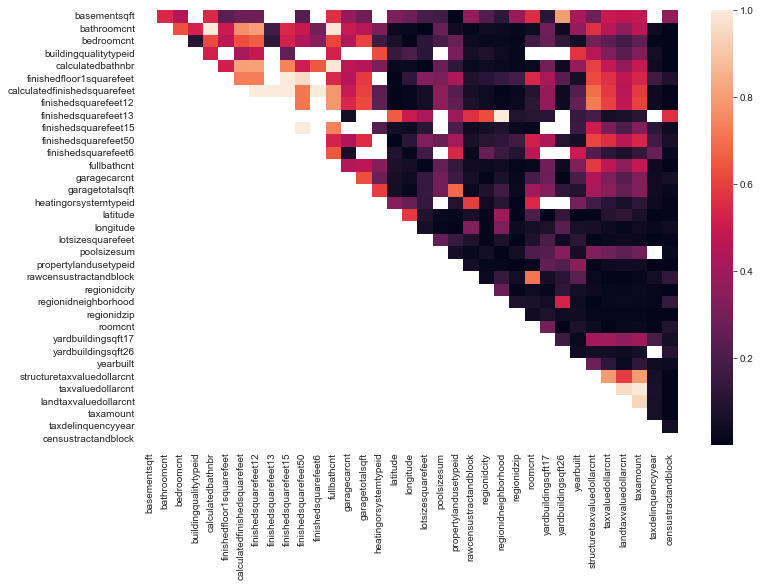

<Figure size 432x288 with 0 Axes>

In [37]:
viz.plot_correlation(actual_data,num_vars)

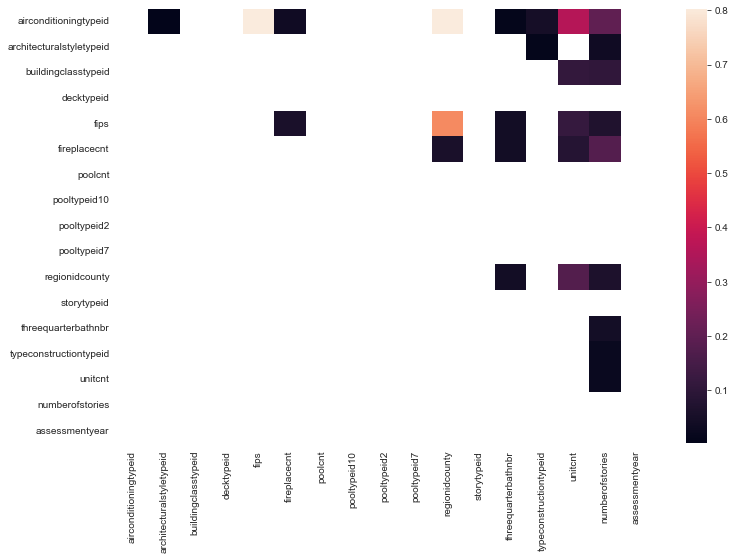

<Figure size 432x288 with 0 Axes>

In [38]:
viz.plot_correlation(actual_data,cat_vars)

# Feature Engineering

DA CAMBIARE -----------------------------------


a.Missing values

c.Rescaling of incorrectly scaled data

d.Standardization

e.Encoding of categorical variables

f.Generation of new feature wherever required.

g.Dropping of redundant feature columns

h.Checking for multi-collinearity and removal of highly correlated features

i.Check for the outliners and removal of outliers.

# Setup

In [39]:
# Train/Test split settings
TEST_SIZE = 0.2
Y = merged_df["logerror"]
X = actual_data

# Missing Values

In [40]:
missing_data

,Missing pct,Missing count
buildingclasstypeid,99.980673,77598
finishedsquarefeet13,99.945885,77571
basementsqft,99.935578,77563
storytypeid,99.935578,77563
yardbuildingsqft26,99.909809,77543
fireplaceflag,99.778388,77441
architecturalstyletypeid,99.733292,77406
typeconstructiontypeid,99.712677,77390
finishedsquarefeet6,99.502661,77227
pooltypeid10,99.400874,77148


In [41]:
print ("Number of unique values in every feature")
for c in X.columns:
    print(c, len(X[c].unique()))

Number of unique values in every feature
airconditioningtypeid 6
architecturalstyletypeid 6
basementsqft 44
bathroomcnt 23
bedroomcnt 17
buildingclasstypeid 3
buildingqualitytypeid 13
calculatedbathnbr 22
decktypeid 2
finishedfloor1squarefeet 1788
calculatedfinishedsquarefeet 4973
finishedsquarefeet12 4869
finishedsquarefeet13 14
finishedsquarefeet15 1725
finishedsquarefeet50 1808
finishedsquarefeet6 351
fips 4
fireplacecnt 6
fullbathcnt 14
garagecarcnt 15
garagetotalsqft 840
hashottuborspa 2
heatingorsystemtypeid 11
latitude 64039
longitude 62462
lotsizesquarefeet 18849
poolcnt 2
poolsizesum 263
pooltypeid10 2
pooltypeid2 2
pooltypeid7 2
propertycountylandusecode 76
propertylandusetypeid 14
propertyzoningdesc 1908
rawcensustractandblock 39189
regionidcity 176
regionidcounty 4
regionidneighborhood 481
regionidzip 390
roomcnt 17
storytypeid 2
threequarterbathnbr 5
typeconstructiontypeid 5
unitcnt 9
yardbuildingsqft17 541
yardbuildingsqft26 60
yearbuilt 137
numberofstories 5
fireplacefla

## Feature Selection
Drop features with high data missing percentage and features that contain information already available.
Let's check the features' dictionary descriptions and see if they are usable. Those which seem useful will be kept.

The following variables are dropped because of their high percentage of missing data, and it would be hard to fill with artificial values.

- **architecturalstyletypeid**: Over 99% of the data is missing.
- **buildingclasstypeid**: Over 99% of the data is missing.
- **finishedfloor1squarefeet**: Over 92% of the data is missing.
- **finishedsquarefeet6**: Over 99% of data is missing, and according to the dictionary description it represents already available information (`calculatedfinishedsquarefeet`).
- **finishedsquarefeet13**: Over 99% of data is missing, and according to the dictionary description it represents already available information (`calculatedfinishedsquarefeet`).
- **finishedsquarefeet15**: Over 96% of data is missing, and according to the dictionary description it represents already available information (`calculatedfinishedsquarefeet`).
- **finishedsquarefeet50**: Over 92% of data is missing, and according to the dictionary description it represents already available information (`calculatedfinishedsquarefeet`).
- **storytypeid**: Over 99% of data is missing.
- **typeconstructiontypeid**: Over 99% of data is missing.
- **basementsqft**: Over 99% of data is missing.
- **fireplaceflag**: Over 99% of data is missing, and according to the dictionary description it represents already available information (`fireplacecnt`).
- **pooltypeid10**: Over 99% of data is missing, and according to the dictionary description it represents already available information (`pooltypeid2`).
- **hashottuborspa**: Over 98% of data is missing, and according to the dictionary description it represents already available information (`pooltypeid2`).
- **taxdelinquencyyear**: Over 96% of data is missing, and according to the dictionary description it represents already available information (`taxdelinquencyflag`).
- **pooltypeid7**: Over 80% of data is missing, and according to the dictionary description it represents already available information (`pooltypeid2`).
- **regionidneighborhood**: Over 60% of data is missing, and information about the region can be obetained from other features.

The following features, while not having a high missing percentage of data, are dropped because they represent information already available from another variable.
- **calculatedbathnbr, fullbathcnt**: Information is already available in `bathroomcnt` which has a lower missing percentage.
- **finishedsquarefeet12**: Information is already available in `calculatedfinishedsquarefeet`.
- **propertyzoningdesc, propertycountylandusecode**: Similar information is already available in `propertylandusetypeid`.
- **regionidzip, regionidcity**: Information is already available in `regionidcounty`, `latitude` and `longitude`. These can be used to obtain information about the location.

Let's drop the aforementioned features.

In [147]:
to_drop = ["architecturalstyletypeid","buildingclasstypeid","finishedfloor1squarefeet","finishedsquarefeet6","finishedsquarefeet13","finishedsquarefeet15","finishedsquarefeet50","storytypeid","typeconstructiontypeid","basementsqft","fireplaceflag","pooltypeid10","hashottuborspa","taxdelinquencyyear","pooltypeid7","calculatedbathnbr","fullbathcnt","finishedsquarefeet12","propertyzoningdesc","propertycountylandusecode","regionidneighborhood","regionidzip","regionidcity"]
X_1 = X.drop(to_drop, axis=1)
X_1

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,decktypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid2,propertylandusetypeid,rawcensustractandblock,regionidcounty,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,censustractandblock
0,NaN,5.0,4.0,NaN,NaN,3760.0,6111.0,4.0,3.0,784.0,NaN,34449407.0,-119254052.0,42688.0,1.0,735.0,NaN,261.0,6.111001e+07,2061.0,11.0,NaN,NaN,NaN,NaN,1982.0,2.0,501928.0,872850.0,2016.0,370922.0,9673.46,NaN,6.111001e+13
1,NaN,2.0,3.0,NaN,66.0,1444.0,6111.0,NaN,1.0,0.0,NaN,34454169.0,-119237898.0,7108.0,NaN,NaN,NaN,261.0,6.111001e+07,2061.0,6.0,NaN,NaN,NaN,NaN,1951.0,1.0,130845.0,436157.0,2016.0,305312.0,5538.80,NaN,6.111001e+13
2,NaN,1.5,3.0,NaN,66.0,1698.0,6111.0,1.0,0.0,0.0,NaN,34365693.0,-119448392.0,2588.0,NaN,NaN,NaN,261.0,6.111001e+07,2061.0,6.0,1.0,NaN,NaN,NaN,1979.0,1.0,193413.0,286606.0,2016.0,93193.0,2987.36,NaN,6.111001e+13
3,NaN,2.0,2.0,NaN,NaN,986.0,6111.0,1.0,1.0,0.0,NaN,34305600.0,-119284000.0,NaN,NaN,NaN,NaN,266.0,6.111002e+07,2061.0,4.0,NaN,NaN,55.0,NaN,1989.0,1.0,90357.0,258888.0,2016.0,168531.0,2706.24,NaN,6.111002e+13
4,NaN,1.0,2.0,NaN,NaN,1170.0,6111.0,1.0,2.0,621.0,NaN,34278012.0,-119257047.0,5643.0,NaN,NaN,NaN,261.0,6.111002e+07,2061.0,5.0,NaN,NaN,NaN,NaN,1948.0,1.0,148752.0,592930.0,2016.0,444178.0,6220.70,NaN,6.111002e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Replacing missing values
The missing values will be replaced following these criteria:
- replace with mean/median/mode using values already present in the feature if missing percentage of data is low
- replace with 0 if the feature asks for a specified category, a simple flag, or a number

In [148]:
NO_QTY = 0

fill_with = {
    "airconditioningtypeid": X_1["airconditioningtypeid"].mode(dropna=True)[0], # the majority of properties have type 1 which is central
    "bathroomcnt": X_1["bathroomcnt"].median(skipna=True),
    "bedroomcnt": X_1["bedroomcnt"].median(skipna=True),
    "buildingqualitytypeid": X_1["buildingqualitytypeid"].median(skipna=True), # using median for missing values since the  condition of the building goes from best (lowest) to worst (highest)
    "decktypeid": NO_QTY, # missing value likely means no deck is present, the only available value is 66, so we can use 0
    "threequarterbathnbr": NO_QTY, # missing value likely means no 3/4 bath is present
    "calculatedfinishedsquarefeet": X_1["calculatedfinishedsquarefeet"].median(skipna=True),
    "fips": X_1["fips"].mode(dropna=True)[0],
    "fireplacecnt": NO_QTY, #missing value likely means no fireplace is present
    "garagecarcnt": NO_QTY, #missing value likely means no garage is present since there is no property with 0 value
    "garagetotalsqft": NO_QTY, #missing value likely means no garage, so 0 square feet
    "heatingorsystemtypeid": X_1["heatingorsystemtypeid"].mode(dropna=True)[0], # the majority of properties have type 2 which is central
    "latitude": X_1["latitude"].median(skipna=True),
    "longitude": X_1["longitude"].median(skipna=True),
    "lotsizesquarefeet": X_1["lotsizesquarefeet"].median(skipna=True),
    "numberofstories": X_1["numberofstories"].median(skipna=True),
    "poolcnt": NO_QTY, #missing value likely means no pool is present
    "poolsizesum": NO_QTY, #missing value likely means no pool so 0 square footage
    "pooltypeid2": NO_QTY, #missing value likely means no pool with spa/hot tub is present
    "propertylandusetypeid": X_1["propertylandusetypeid"].mode(dropna=True)[0], # only 4% of missing data, seems reasonable to use the mode which is "Single Family Residential" (id = 261)
    "rawcensustractandblock": X_1["rawcensustractandblock"].mode(dropna=True)[0],
    "censustractandblock": X_1["censustractandblock"].mode(dropna=True)[0],
    "regionidcounty": X_1["regionidcounty"].mode(dropna=True)[0],
    "roomcnt": X_1["roomcnt"].mode(dropna=True)[0],
    "unitcnt": X_1["unitcnt"].mode(dropna=True)[0], # the majority of properties are built into 1 unit
    "yardbuildingsqft17": NO_QTY, #missing value likely means no patio in yard
    "yardbuildingsqft26": NO_QTY, #missing value likely means no building in yard
    "yearbuilt": X_1["yearbuilt"].mode(dropna=True)[0],
    "taxvaluedollarcnt": X_1["taxvaluedollarcnt"].median(skipna=True),
    "structuretaxvaluedollarcnt": X_1["structuretaxvaluedollarcnt"].median(skipna=True),
    "landtaxvaluedollarcnt": X_1["landtaxvaluedollarcnt"].median(skipna=True),
    "taxamount": X_1["taxamount"].median(skipna=True),
    "assessmentyear": X_1["assessmentyear"].mode(dropna=True)[0],
    "taxdelinquencyflag": NO_QTY # missing value likely means that the properties are not tax delinquent (the only value is Y)
}

X_2 = X_1.fillna(fill_with)
X_2.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         77613 non-null  float64
 1   bathroomcnt                   77613 non-null  float64
 2   bedroomcnt                    77613 non-null  float64
 3   buildingqualitytypeid         77613 non-null  float64
 4   decktypeid                    77613 non-null  float64
 5   calculatedfinishedsquarefeet  77613 non-null  float64
 6   fips                          77613 non-null  float64
 7   fireplacecnt                  77613 non-null  float64
 8   garagecarcnt                  77613 non-null  float64
 9   garagetotalsqft               77613 non-null  float64
 10  heatingorsystemtypeid         77613 non-null  float64
 11  latitude                      77613 non-null  float64
 12  longitude                     77613 non-null  float64
 13  l

There is no more missing values.

### Transform incorrectly scaled variables
As we can see in the data dictionary, the variables latitude and longitude have been multiplied. So we will scale them to their original value.

In [149]:
X_2[['latitude', 'longitude']] = (X_2[['latitude', 'longitude']])/(10**6)

### Save the filled dataset

In [131]:
X_2.to_csv('../data/filled_properties_2017.csv', index=False)

# Encoding Categorical Data

What feature contains categorical data?
After reading the data dictionary carefully, we can say that the features containing the following words in their name are categorical data: "id"; "flag"; "has"; "code"; or "desc"; let's find them and encode them with One Hot Encoding.

In [182]:
# Identifier contained in categorical features' name
is_cat = ["id", "flag", "has", "code", "desc"]
cat_vars = fe.get_features_from_name(df=X_2,
                                         identifiers=is_cat)
cat_vars_name = cat_vars.columns
num_vars_name = [var for var in X_2.columns if var not in cat_vars_name]
cat_vars_name

Index(['airconditioningtypeid', 'buildingqualitytypeid', 'decktypeid',
       'heatingorsystemtypeid', 'pooltypeid2', 'propertylandusetypeid',
       'regionidcounty', 'taxdelinquencyflag'],
      dtype='object')

## Visualization
Before One-Hot Encoding

### Distribution of features

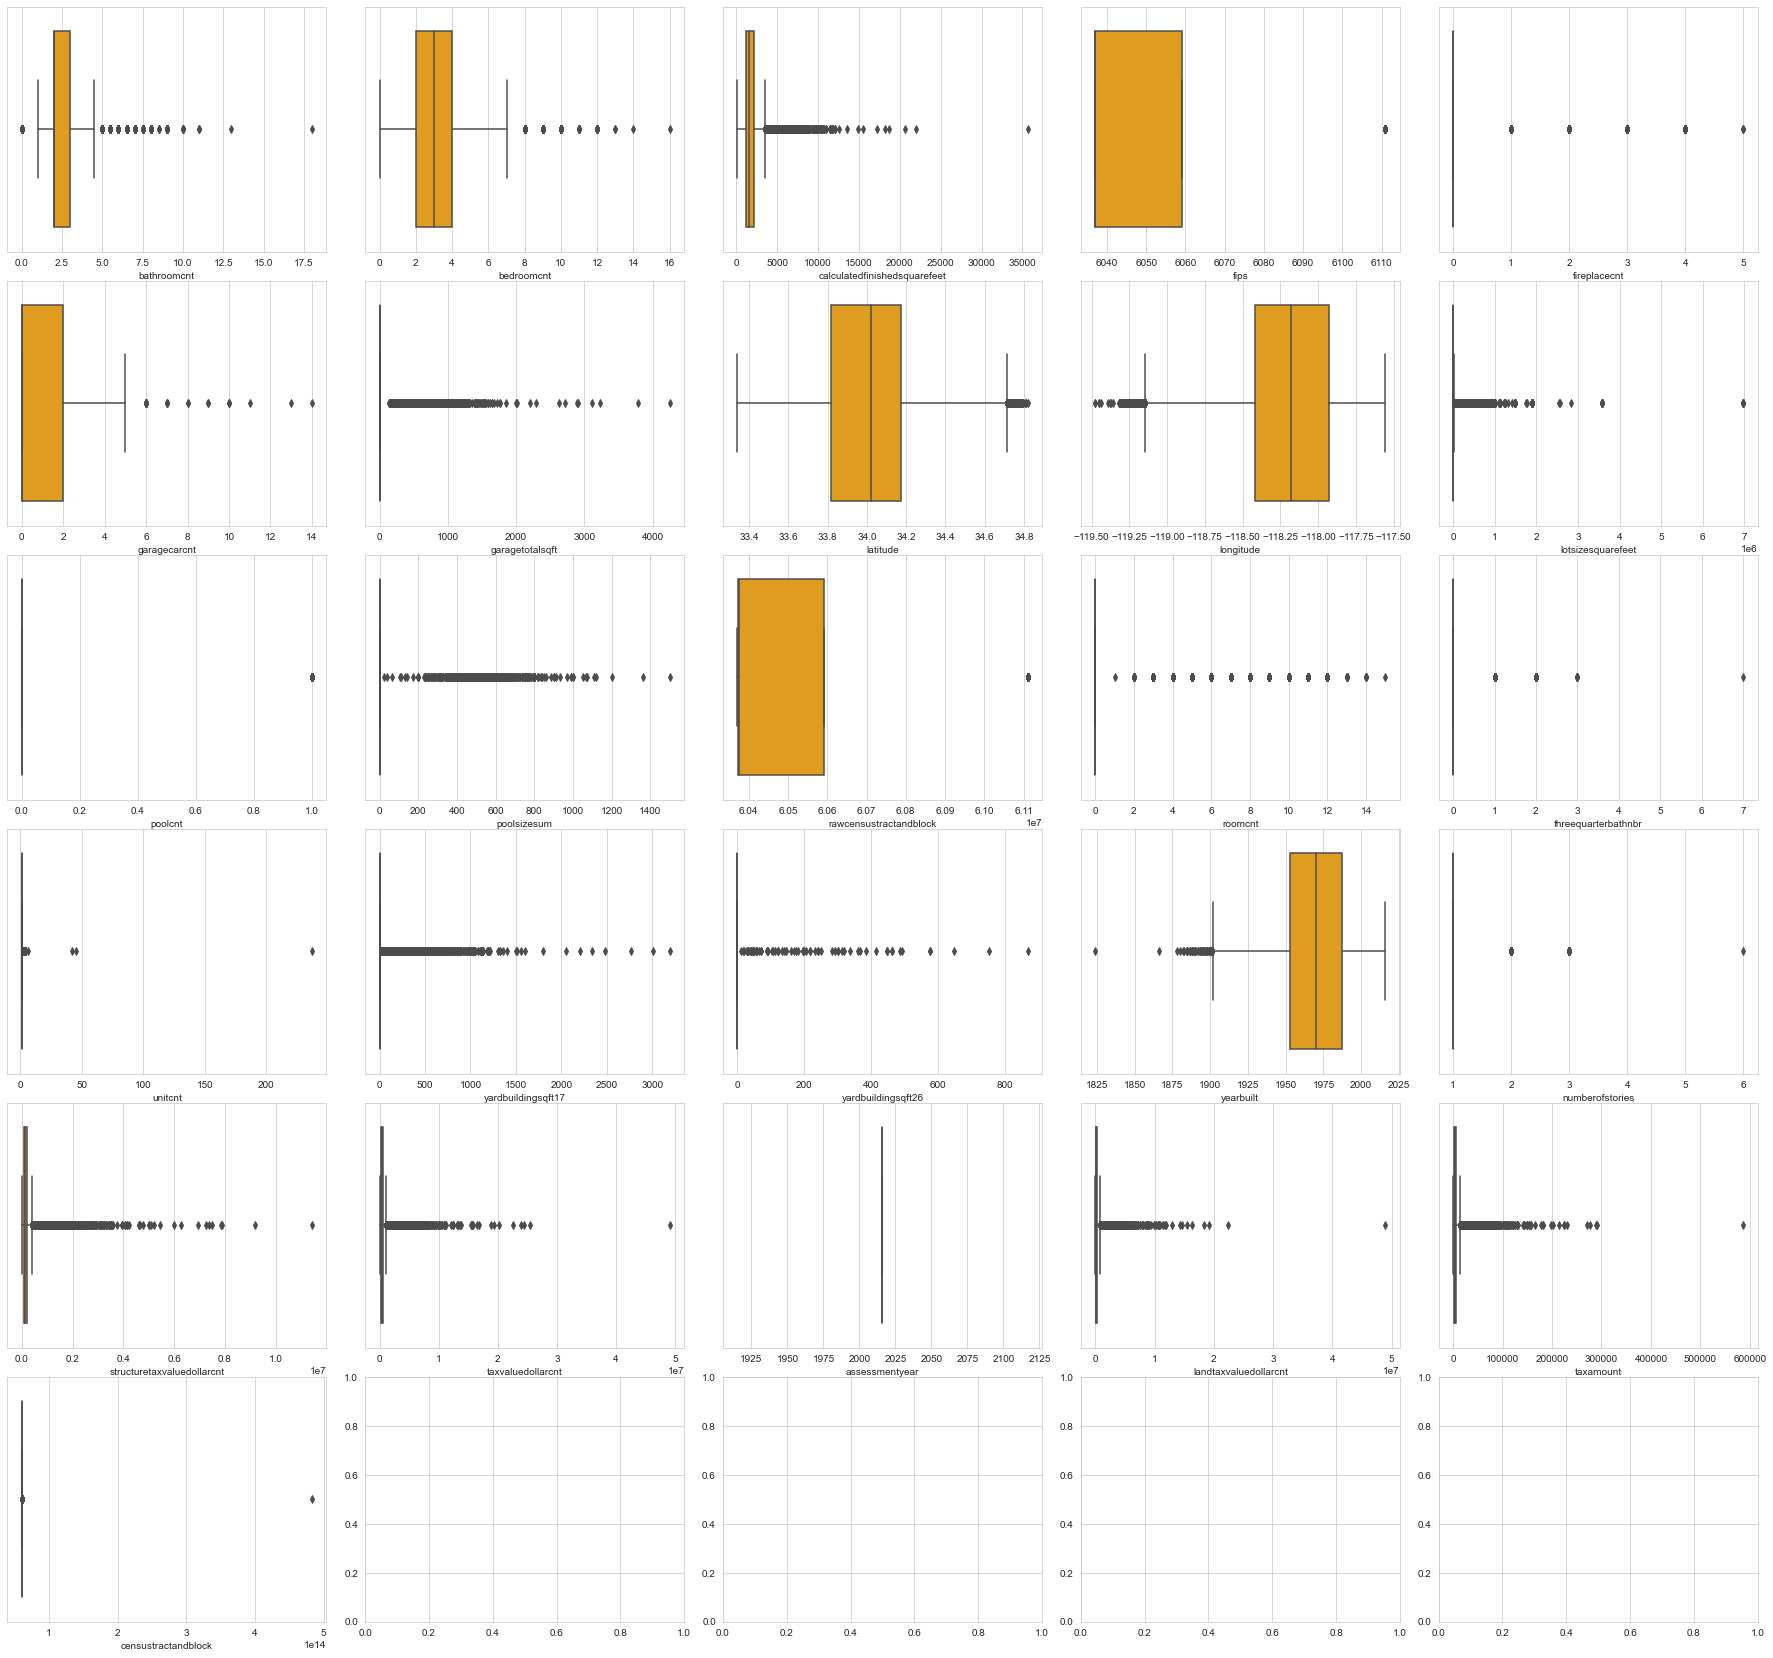

In [183]:
viz.plot_feature_distribution(X_2,num_vars_name,subplot_size=(5, 4))

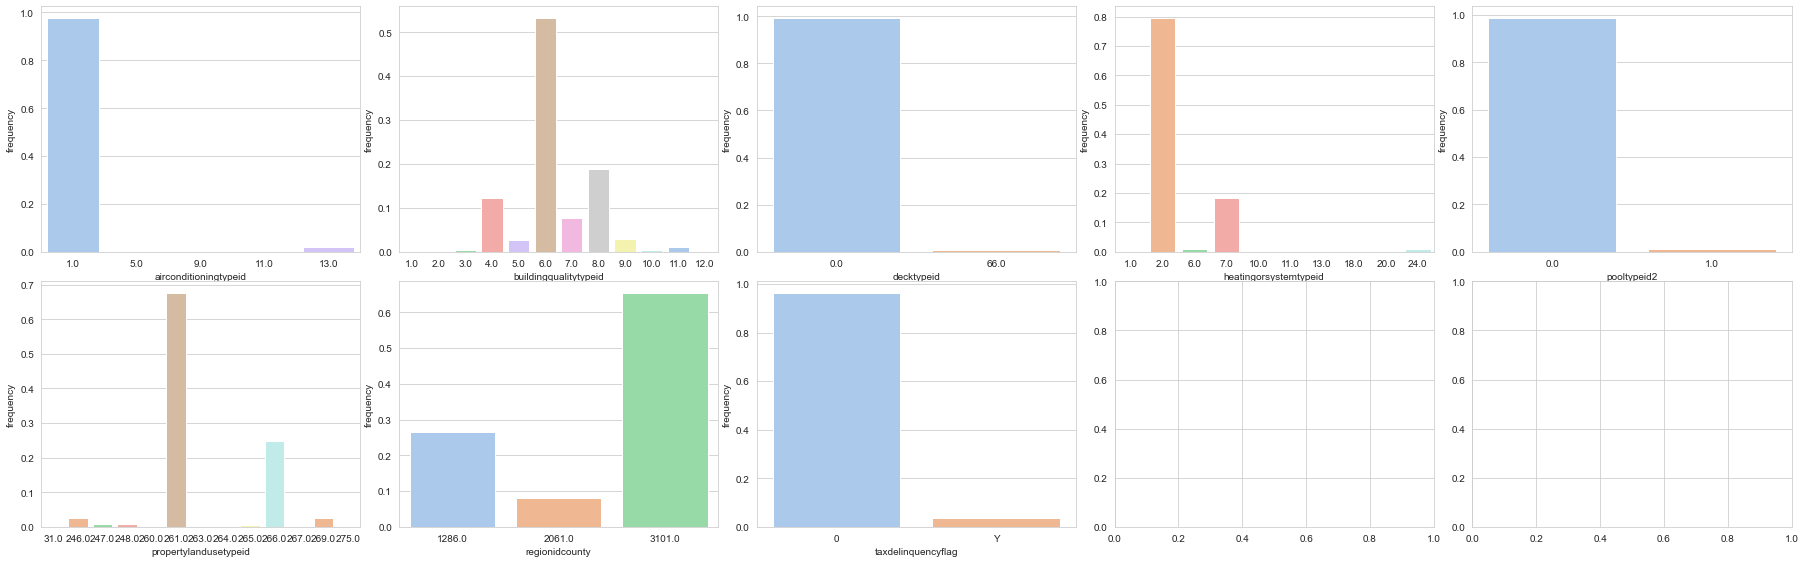

In [184]:
viz.plot_feature_distribution(X_2,cat_vars_name,subplot_size=(5, 4),cat = True)

### Correlation

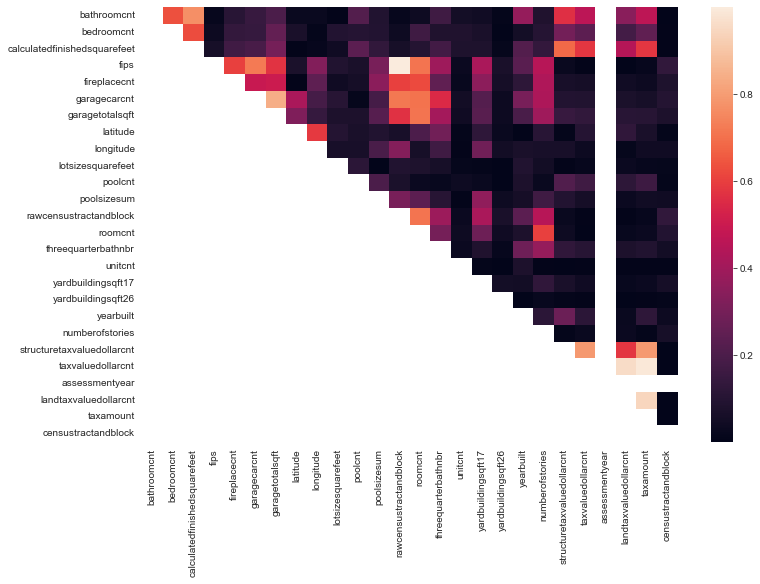

<Figure size 432x288 with 0 Axes>

In [185]:
viz.plot_correlation(X_2,num_vars_name)

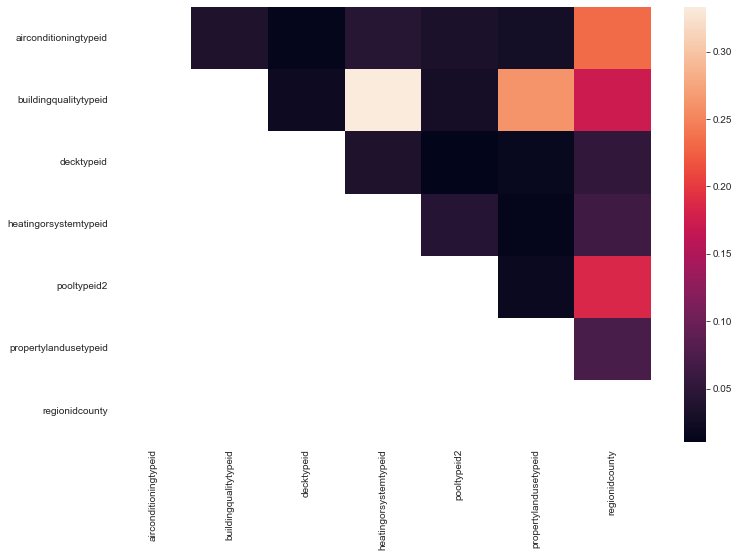

<Figure size 432x288 with 0 Axes>

In [186]:
viz.plot_correlation(X_2,cat_vars_name)

#### Train/Test Split

In [188]:
X2_train_80, X2_test, Y_train_80, Y_test = train_test_split( X_2, Y,test_size=0.20)
X2_split = fe.TrainTestSplit(X2_train_80, X2_test, Y_train_80, Y_test)
X2_split.x_train.info(verbose=True, show_counts=True)
X2_split.x_test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62090 entries, 17579 to 75352
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         62090 non-null  float64
 1   bathroomcnt                   62090 non-null  float64
 2   bedroomcnt                    62090 non-null  float64
 3   buildingqualitytypeid         62090 non-null  float64
 4   decktypeid                    62090 non-null  float64
 5   calculatedfinishedsquarefeet  62090 non-null  float64
 6   fips                          62090 non-null  float64
 7   fireplacecnt                  62090 non-null  float64
 8   garagecarcnt                  62090 non-null  float64
 9   garagetotalsqft               62090 non-null  float64
 10  heatingorsystemtypeid         62090 non-null  float64
 11  latitude                      62090 non-null  float64
 12  longitude                     62090 non-null  float64
 1

In [190]:
X2_split.x_train[cat_vars_name].nunique()

airconditioningtypeid     5
buildingqualitytypeid    12
decktypeid                2
heatingorsystemtypeid     9
pooltypeid2               2
propertylandusetypeid    13
regionidcounty            3
taxdelinquencyflag        2
dtype: int64

## One-Hot Encoding

In [ ]:
# ohe_enc = fe.ohe_fit(cat_vars)
#
# x_train_ord = fe.ohe_transform(df=X2_train_80, cat_features=cat_vars_name, ohe=ohe_enc)
# x_test_ord = fe.ohe_transform(df=X2_test, cat_features=cat_vars_name, ohe=ohe_enc)
# lvl2_ohe = fe.TrainTestSplit(x_train_ord, x_test_ord, Y_train_80, Y_test)

# Correlated features

By checking the dictionary descriptions of the features we can see that some have the same information, and others have the same meaning.
They are the following:
- rawcensustractandblock, censustractandblock
- bathroomcnt, calculatedbathnbr, fullbathcnt
- calculatedfinishedsquarefeet, finishedsquarefeet12,finishedsquarefeet13, finishedsquarefeet15,finishedsquarefeet6, finishedsquarefeet50, finishedfloor1squarefeet

In [ ]:
cor_matrix = X_1.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones_like(cor_matrix, dtype=bool), k=1))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(to_drop)
missing_data.filter(items=to_drop, axis=0)

In [ ]:
upper_tri["finishedsquarefeet12"]>0.9

da [notebook crasto](https://www.kaggle.com/code/devanshm/zillow-end-to-end-ml-workflow-top-250-0-06416/notebook)

## Dropping Outliers

Since the data is mostly normally distributed outside of the outliers, we will drop all values that are more than 2.5 standard deviations away from the mean. For reference, for the standard normal distribution, 68% of the observations lie within 1 standard deviation of the mean; 95% lie within two standard deviation of the mean; and 99.9% lie within 3 standard deviations of the mean.

In [ ]:
highest_thres = y.mean() + 2.5*y.std()
lowest_thres = y.mean() - 2.5*y.std()
print("Highest allowed",highest_thres)
print("Lowest allowed", lowest_thres)

In [ ]:
# Only the training set outliers will be dropped (not validation or testing set to ensure model performs well on outliers too)
y = y[y > lowest_thres]
y = y[y < highest_thres]

# Update original Housing dataframe
housing = merged_df[merged_df.logerror > lowest_thres]
housing = housing[housing.logerror < highest_thres]

In [ ]:
# Drop rows containing either 75% or more NaN Values
percent = 75.0
min_count =  int(((100-percent)/100)*housing.shape[1] + 1)
housing = housing.dropna(axis=0, thresh=min_count)
housing.shape

In [ ]:
y.hist(bins=100, figsize=(8,5))
plt.show()

In [ ]:
#Check the new distribution
sns.distplot(y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           loc='best')
plt.ylabel('Frequency')
plt.title('LogError distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

The skew seems now corrected and the data appears better normally distributed.

next part is Create Test/Train datasets (per feat eng penso)